<h1>Task 3.3</h1>

In [1]:
import mlhelper as mlh
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, \
mean_absolute_error, balanced_accuracy_score, accuracy_score, \
roc_auc_score, ConfusionMatrixDisplay, PredictionErrorDisplay
from sklearn.dummy import DummyRegressor, DummyClassifier
from scipy.stats import ttest_ind, ttest_rel

<h2>Regression Model for GWP</h2>
In this section, we build a Multi-layer Perceptron regression model for the GWP dataset. We will:
<ul>
    <li>Split GWP into training and testing</li>
    <li>Perform Cross Validation on an MLP</li>
    <li>Perform Hyperparameter optimisation</li>
    <li>Evaluate performance</li>
</ul>

<h3>Training and Optimisation</h3>

In [3]:
gwp = mlh.GWPDataset("gwp_assessment.csv")

We perform grid search cross validation for the SVR. Hyperparameters and their ranges were chosen by consulting sklearn docs. We search the following parameter space and use the following scores:

In [4]:
MLP_param_space = [
  {'hidden_layer_sizes': [(100), (100, 100), (100, 100, 100)], 
   'solver': ['adam', 'sgd'],}]

We use the following metrics. All standard scores for evaluating regression models.

In [5]:
MLP_scores = {
    "r2_score": make_scorer(r2_score),
    "mse_score": make_scorer(mean_squared_error, greater_is_better=False),
    "mae_score": make_scorer(mean_absolute_error, greater_is_better=False)
}

Now we run grid search for an MLP across this parameter space. We choose the model with the greatest r2 score.

In [6]:
mlp_results = mlh.train(MLPRegressor(), gwp, MLP_param_space, MLP_scores, 5, refit="r2_score")

<h3>Evaluation</h3>

Through the process of grid search, we find our best MLP has the following hyperparameters:

In [10]:
mlp_results["grid_search"].best_params_

{'hidden_layer_sizes': (100, 100), 'solver': 'adam'}

With the test scores:

In [7]:
mlp_results["test_scores"]

{'r2_score': 0.17118247136509912,
 'mse_score': -0.02654685379358445,
 'mae_score': -0.11423913572036284}

As we did in the previous task, let's see how a dummy regressor performs. In this case, the dummy regressor always predicts the mean.

In [10]:
gwp_x_train, gwp_x_test, gwp_y_train, gwp_y_test = mlp_results["dataset"]

dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(gwp_x_train, gwp_y_train)
print("dummy r2 score:", dummy_regressor.score(gwp_x_test, gwp_y_test))

dummy r2 score: -3.2232634892714884e-05


Clearly, our regressor is better than the dummy regressor, but the r2 score is nonetheless quite low for MLP as it was for SVR in the previous task.

<h4>Visualisations</h4>

<h5>Prediction Error</h5>

Let's visualise the prediction error on the test data:

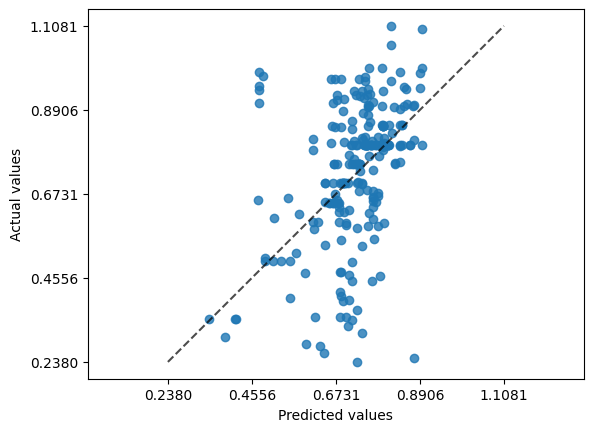

In [19]:
PredictionErrorDisplay(y_true=gwp_y_test, 
                       y_pred=mlp_results["best_model"].predict(gwp_x_test)
                      ).plot(kind="actual_vs_predicted")

MLP seems to overpredict and underpredict with roughly equal measure. It is at its best with values near the centre of the ditribution.

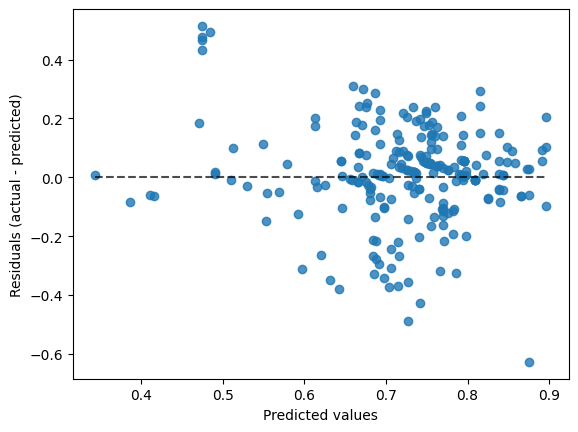

In [20]:
PredictionErrorDisplay(y_true=gwp_y_test, 
                       y_pred=mlp_results["best_model"].predict(gwp_x_test)
                      ).plot(kind="residual_vs_predicted")

Quite a wide range of residuals. Again, both underestimating and overestimating wildly.

<h2>Classification Model for Star Dataset</h2>
In this section we build an KNN classifier to classify the star dataset. We will do the following:
<ul>
    <li>Split Star Dataset into training and testing</li>
    <li>Perform Cross Validation on a KNN</li>
    <li>Perform Hyperparameter optimisation</li>
    <li>Evaluate performance</li>
</ul>

In [21]:
star = mlh.StarDataset("star_assessment.csv")

We search the following parameter space, varying both the number of neighbours to consider as well as the way by which neighbours' contributions are weighted:

In [22]:
knn_param_space = [
  {'n_neighbors': [5, 10, 20, 50], 'weights': ['uniform', 'distance']},
 ]

And we use the following standard classification metrics. We look at balanced accuracy due to the class imbalance in the star dataset:

In [30]:
knn_scores = {
    "accuracy_score": make_scorer(accuracy_score),
    "balanced_accuracy_score": make_scorer(balanced_accuracy_score),
}

We stratify the training samples to improve performance.

In [24]:
knn_results = mlh.train(KNeighborsClassifier(), star, knn_param_space, knn_scores, 5, refit="accuracy_score", stratify=star.processed_Y())

<h3>Evaluation</h3>

Through the process of grid search, we find our best SVC has the following hyperparameters:

In [26]:
knn_results["grid_search"].best_params_

{'n_neighbors': 5, 'weights': 'distance'}

With test scores:

In [27]:
knn_results["test_scores"]

{'accuracy_score': 0.90905, 'balanced_accuracy_score': 0.8778850374875594}

To get a sense of the power of our classifier, let's first see how a dummy classifier performs. In this case, the dummy regressor always predicts the mean.

In [29]:
star_x_train, star_x_test, star_y_train, star_y_test = knn_results["dataset"]

dummy_classifier = DummyClassifier(strategy='uniform')
dummy_classifier.fit(star_x_train, star_y_train)
print("dummy accuracy score:",
      dummy_classifier.score(star_x_test, star_y_test))

dummy accuracy score: 0.33


Our KNN classifier is doing much better than a dummy baseline.

<h4>Visualisations</h4>

In [32]:
star_class_labels=["galaxy", "quasar", "star"]

<h5>Confusion Matrix</h5>

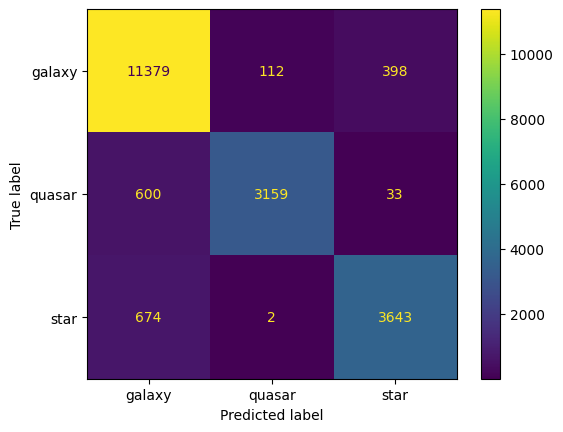

In [33]:
ConfusionMatrixDisplay.from_estimator(knn_results["best_model"], 
                                      star_x_test,
                                      star_y_test,
                                     display_labels=star_class_labels)

As one might expect, the most represented class in the dataset is the best predicted with the other two sharing a similar recall.

<h2>Hypothesis Testing</h2>

We now perform hypothesis testing on the models from task 3.2 and task 3.3.
For each problem, we will test if the null hypothesis holds for 10-fold cross validation on their respective datasets.

<h3>Regression Problem</h3>
First of all, we test the null hypothesis for the regression problem. Hyperparameters are taken from the results of hyperparameter optimisation.

In [34]:
x_train, x_test, y_train, y_test = train_test_split(
    gwp.processed_X(), gwp.processed_Y(), train_size=0.8, shuffle=True)

mlp = MLPRegressor(hidden_layer_sizes=(100, 100), solver='adam')
svr = SVR(C=1000, gamma=0.001, kernel='rbf')

mlp.fit(x_train, y_train)
svr.fit(x_train, y_train)

mlp_scores = cross_val_score(mlp, x_test, y_test, cv=10)
svr_scores = cross_val_score(svr, x_test, y_test, cv=10)

In [35]:
ttest_ind(mlp_scores, svr_scores)

Ttest_indResult(statistic=0.427180035421075, pvalue=0.674314449371352)

Since pvalue > 0.05, we conclude that the null hypothesis holds and therefore SVR and MLP are equally good (or bad depending how you look at it) at the regression task.

<h3>Classification Task</h3>
Now we test the null hypothesis for the classification problem. Hyperparameters are taken from the results of hyperparameter optimisation.

In [36]:
x_train, x_test, y_train, y_test = train_test_split(
    star.processed_X(), star.processed_Y(), train_size=0.8, shuffle=True, 
    stratify=star.processed_Y())

knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
svc = SVC(C=100, kernel='linear')

knn.fit(x_train, y_train)
svc.fit(x_train, y_train)

knn_scores = cross_val_score(knn, x_test, y_test, cv=10)
svc_scores = cross_val_score(svc, x_test, y_test, cv=10)

In [37]:
ttest_ind(knn_scores, svc_scores)

Ttest_indResult(statistic=-36.006275928526335, pvalue=3.1602278417738516e-18)

Since pvalue < 0.05, we conclude that the null hypothesis does not hold. Therefore, we conclude that knn and svc are not equal in terms of their performance on the classification task.

<h2>Markdown Question</h2>

The hypothesis I was testing was the null hypothesis. Namely, given two sets of scores for each problem, I determined whether the models which produced those scores were equally effective. 

For the regression problem, the null hypothesis was accepted with a p-value of 0.67. This p-value tells us there is a high probability that the null hypothesis holds. Therefore, both the MLP and SVR regressors I developed have equal effectiveness at solving this problem.

For the classification problem, the null hypothesis was rejected with a p-value of 3.16e-18. This p-value is less than 0.05. It is widely accepted that p-values less than 0.05 indicate a hypothesis does not hold. Therefore, the SVC and KNN classifiers do not have equal effectiveness at solving this problem.